# Problem-statement

In this notebook, our problem-statement is to analyse S&P500 stock prices (We will analyze 10 popular stocks and forecast the future prices) and build forecasting models that beat the market.

# We'll be answering the following questions along the way:

- What was the change in price of the stock over time?
- What was the daily return of the stock on average?
- What was the moving average of the various stocks?
- What was the correlation between different stocks'?

In [1]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from scipy import stats
import matplotlib.dates as mdates
from plotly import tools
import plotly.tools as tls
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, plot, iplot
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

init_notebook_mode(connected=True)
%matplotlib inline
# matplotlib defaults
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install mplfinance

In [3]:
!pip install pystan==2.19.1.1
!pip install fbprophet

In [4]:
!pip install pmdarima

# DATA ANALYSIS AND VISUALIZATIONS 

In [5]:
df = pd.read_csv('/Users/mac/Downloads/all_stocks_5yr.csv')
df.head()


date   open   high    low  close    volume Name
0  2013-02-08  15.07  15.12  14.63  14.75   8407500  AAL
1  2013-02-11  14.89  15.01  14.26  14.46   8882000  AAL
2  2013-02-12  14.45  14.51  14.10  14.27   8126000  AAL
3  2013-02-13  14.30  14.94  14.25  14.66  10259500  AAL
4  2013-02-14  14.94  14.96  13.16  13.99  31879900  AAL

In [6]:
# define a function to get all the information needed
def information_func(df):
    print("unique stocks available in dataset", df['Name'].nunique())
    print('-----'*10)
    print('dataset info')
    df.info()
    print('-----'*10)
    null = df.isnull().sum()
    print("missing values:\n", null)
    print('-----'*10)
    delta = (pd.to_datetime(df['date']).max() - pd.to_datetime(df['date']).min())
    print("Time range of stocks dataset:\n", delta)

In [7]:
information_func(df)

unique stocks available in dataset 505
--------------------------------------------------
dataset info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619040 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   date    619040 non-null  object 
 1   open    619029 non-null  float64
 2   high    619032 non-null  float64
 3   low     619032 non-null  float64
 4   close   619040 non-null  float64
 5   volume  619040 non-null  int64  
 6   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(2)
memory usage: 33.1+ MB
--------------------------------------------------
missing values:
 date       0
open      11
high       8
low        8
close      0
volume     0
Name       0
dtype: int64
--------------------------------------------------
Time range of stocks dataset:
 1825 days 00:00:00


# Data cleaning

In [8]:
# change name to ticks
rdf = df.rename(columns={'Name':'ticks'})

# drop the null as they a few values and time-series won't be affected by such values
rdf.dropna(inplace=True)

# change the dtype of date column
new_df = rdf.copy()
new_df.loc[:, 'date'] = pd.to_datetime(rdf.loc[:, 'date'], format='%Y/%m/%d')

# new dataframe info
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 619029 entries, 0 to 619039
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    619029 non-null  datetime64[ns]
 1   open    619029 non-null  float64       
 2   high    619029 non-null  float64       
 3   low     619029 non-null  float64       
 4   close   619029 non-null  float64       
 5   volume  619029 non-null  int64         
 6   ticks   619029 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 37.8+ MB


# Top 10 stock tickers by average trade volume

In [9]:
# using a for loop to get the top 10 stock ticker by getting the mean volume
mean_dict = {}

for key in new_df['ticks'].unique():
    value = new_df[new_df['ticks']== key]['volume'].mean()
    mean_dict[key]= value
    
print("Length of the mean of ticks dictionary:", len(mean_dict))

# convert dict to pandas dataframe
avaerage_s = pd.Series(mean_dict).transpose()
top10_s = avaerage_s.sort_values(ascending=False)[:10]

print("Top 10 company tickers with highest average traded stock volume:\n", top10_s)    
    

Length of the mean of ticks dictionary: 505
Top 10 company tickers with highest average traded stock volume:
 BAC     9.363380e+07
AAPL    5.404790e+07
GE      4.211568e+07
F       3.446237e+07
FB      3.435927e+07
MSFT    3.386946e+07
AMD     3.251904e+07
MU      3.024841e+07
INTC    2.932671e+07
CSCO    2.865435e+07
dtype: float64


In [10]:
# function to return top 10 sub dataframe
def subdataframe(df, tick):
    
    ticks = list(top10_s.index)
    assert tick in ticks, """Stock tick does not belong to top 10 stocks by trade volume, please try any of these:\n
    ['BAC', 'AAPL', 'GE', 'F', 'FB', 'MSFT', 'AMD', 'MU', 'INTC', 'CSCO']"""
    
    ndf = new_df[new_df['ticks'] == tick]
    return ndf

In [11]:
company_dict = {'BAC':'Bank of America', 
                'AAPL':'Apple', 
                'GE':'General Electric', 
                'F':'Ford Motor Company', 
                'FB':'Facebook', 
                'MSFT':'Microsoft', 
                'AMD':'Adavanced Micro Devices', 
                'MU':'Micron Technology', 
                'INTC':'Intel Corp', 
                'CSCO':'Cisco'
               }

bac_df = subdataframe(new_df, 'BAC')
aapl_df = subdataframe(new_df, 'AAPL')
ge_df = subdataframe(new_df, 'GE')
f_df = subdataframe(new_df, 'F')
fb_df = subdataframe(new_df, 'FB')
msft_df = subdataframe(new_df, 'MSFT')
amd_df = subdataframe(new_df, 'AMD')
mu_df = subdataframe(new_df, 'MU')
intc_df = subdataframe(new_df, 'INTC')
csco_df = subdataframe(new_df, 'CSCO')

# define a function to return daily return and company column
def dailyfunc(df):
    df['daily return'] = ((df['close'] - df['open'])/df['open'])*100
    df.style.format('{:.2f}%', subset='daily return')
    df['daily_mean'] = (df['open'] + df['close'] + df['high'] + df['low'])/4
    df['co_name'] = company_dict[df['ticks'].unique()[0]]
    return df

bac_df = dailyfunc(bac_df)
aapl_df = dailyfunc(aapl_df)
ge_df = dailyfunc(ge_df)
f_df = dailyfunc(f_df)
fb_df = dailyfunc(fb_df)
msft_df = dailyfunc(msft_df)
amd_df = dailyfunc(amd_df)
mu_df = dailyfunc(mu_df)
intc_df = dailyfunc(intc_df)
csco_df = dailyfunc(csco_df)


In [12]:
bac_df.head()

date   open   high    low   close     volume ticks  daily return  \
72870 2013-02-08  11.86  11.90  11.72  11.760  145217221   BAC     -0.843170   
72871 2013-02-11  11.73  11.90  11.67  11.860  103499848   BAC      1.108269   
72872 2013-02-12  11.87  12.34  11.78  12.245  231771561   BAC      3.159225   
72873 2013-02-13  12.35  12.42  12.05  12.170  192478919   BAC     -1.457490   
72874 2013-02-14  12.09  12.27  12.07  12.130  143901737   BAC      0.330852   

       daily_mean          co_name  
72870    11.81000  Bank of America  
72871    11.79000  Bank of America  
72872    12.05875  Bank of America  
72873    12.24750  Bank of America  
72874    12.14000  Bank of America

# Closing stock price visualization & maximum price during 5 years 

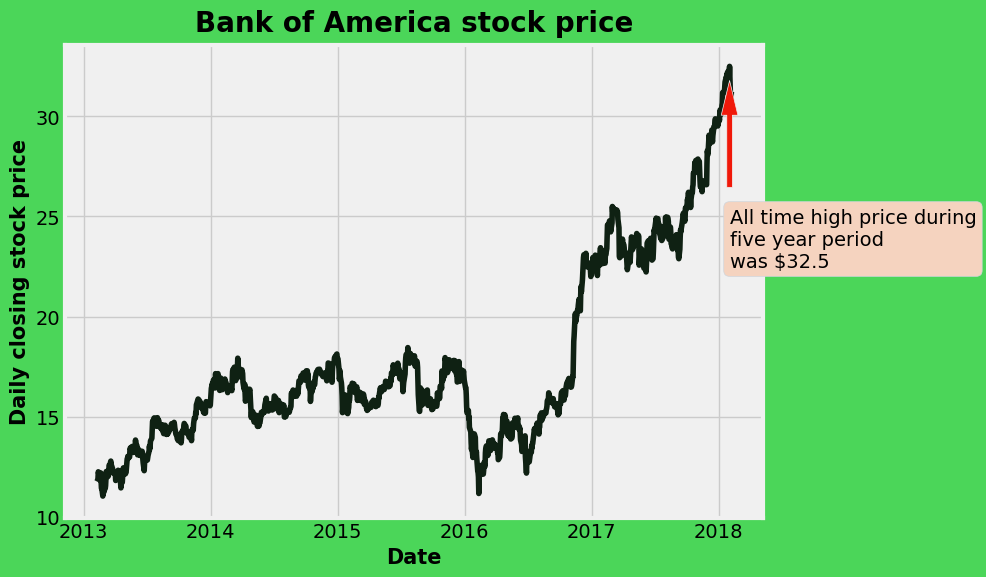

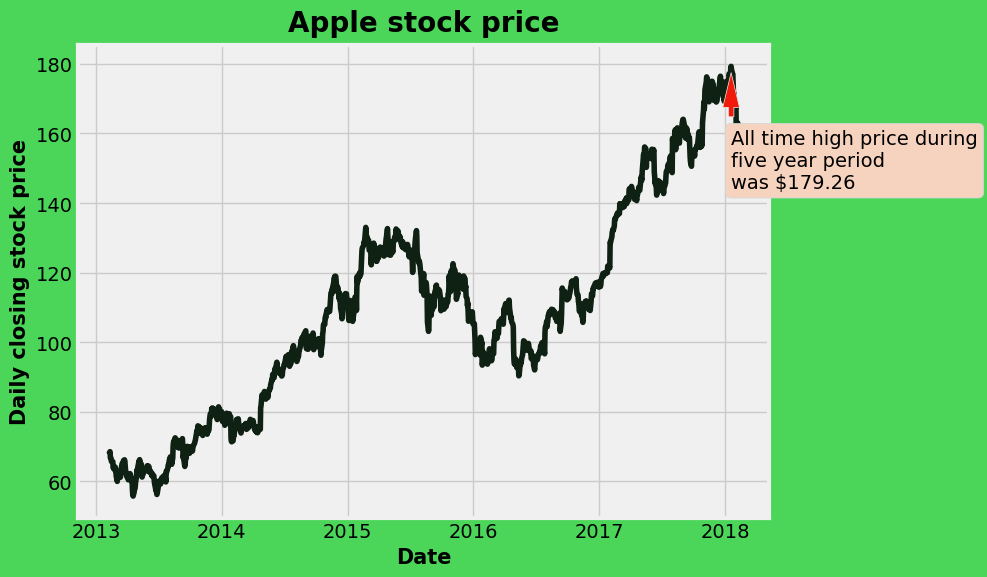

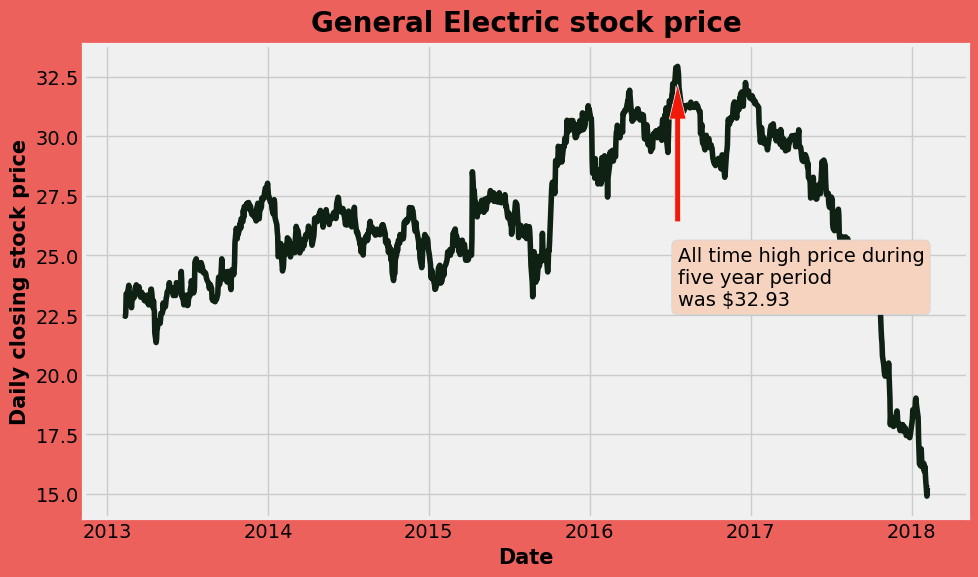

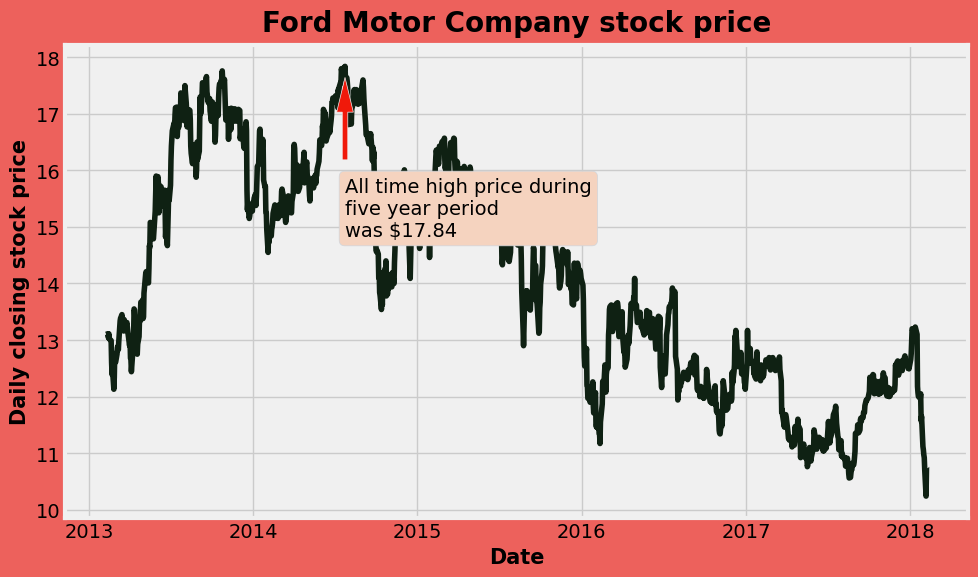

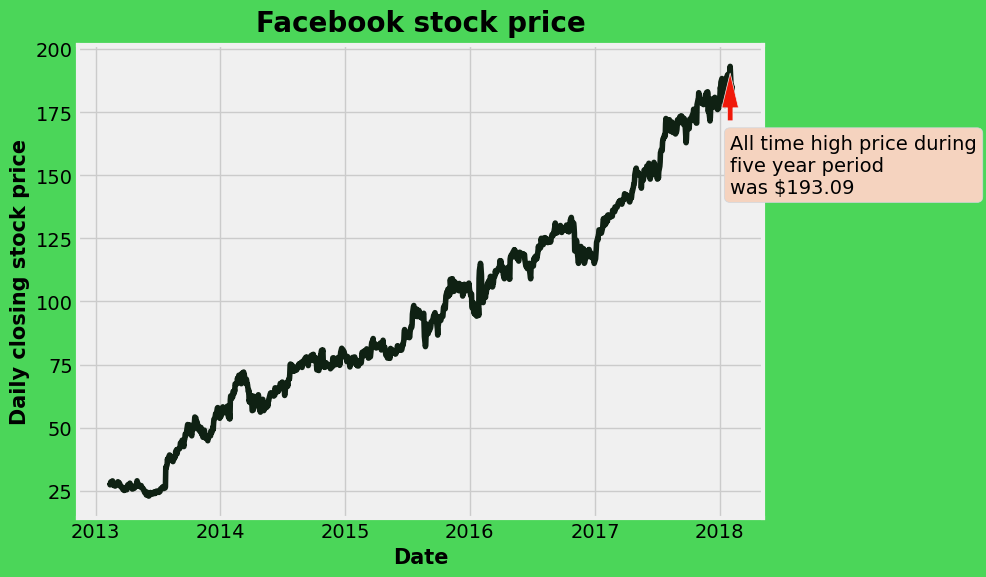

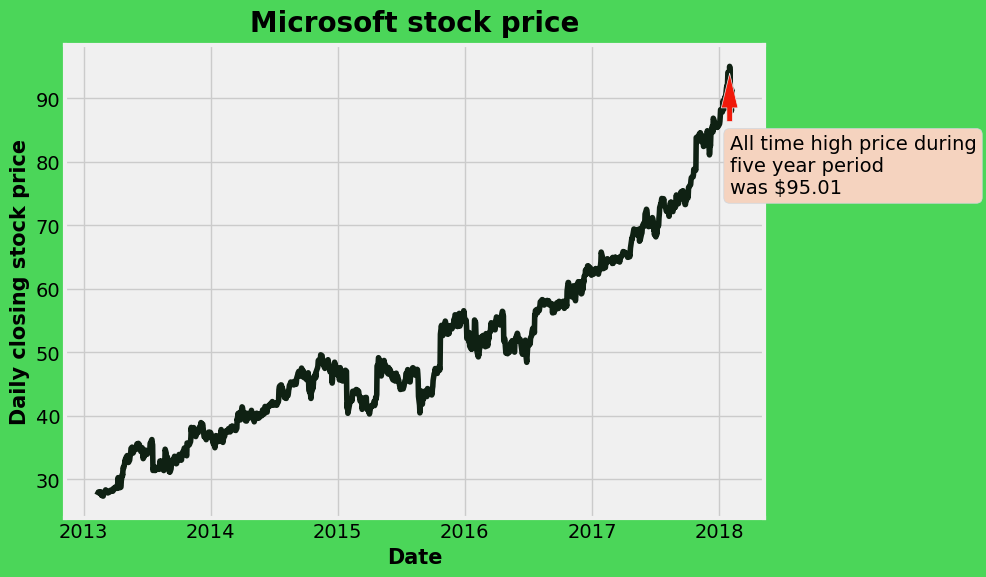

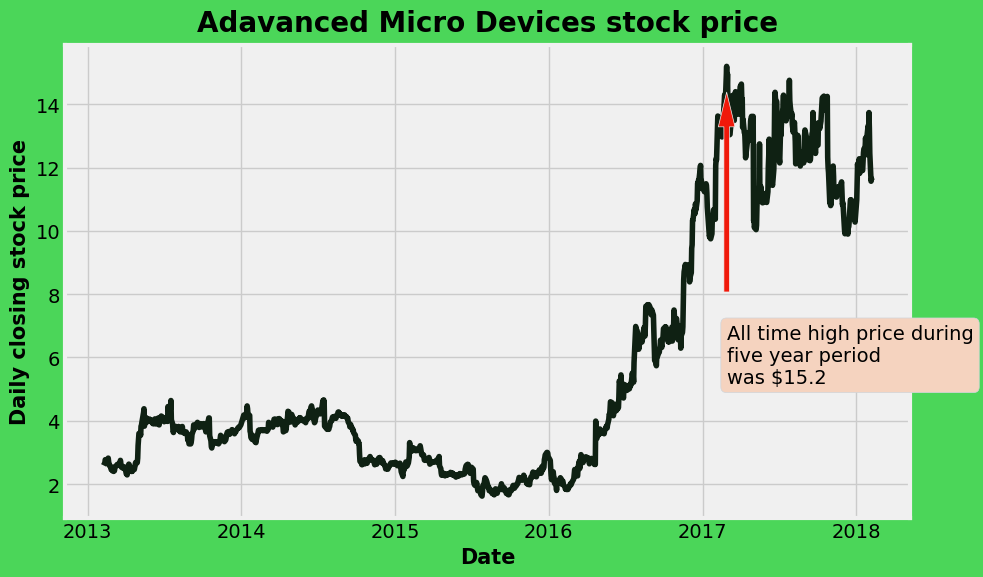

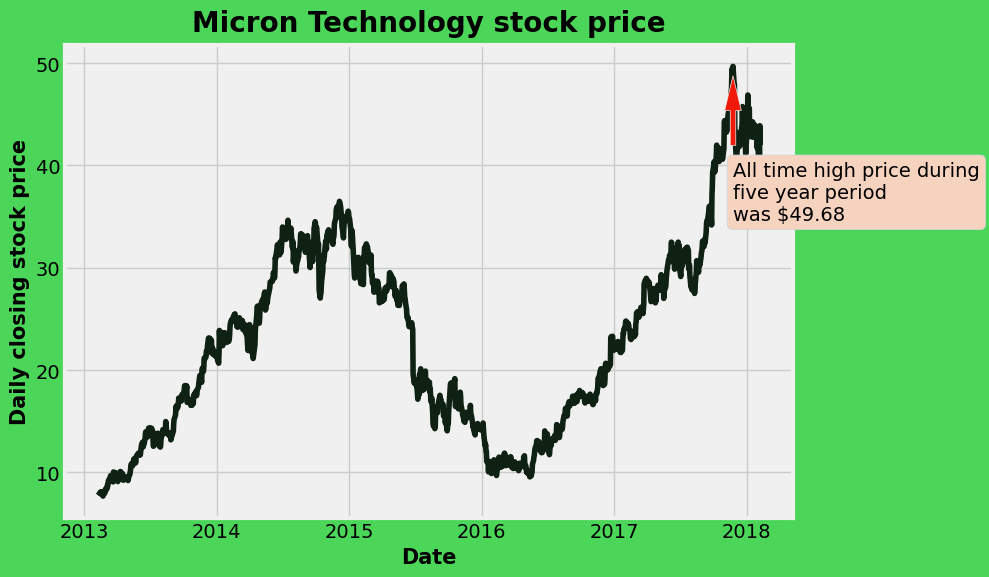

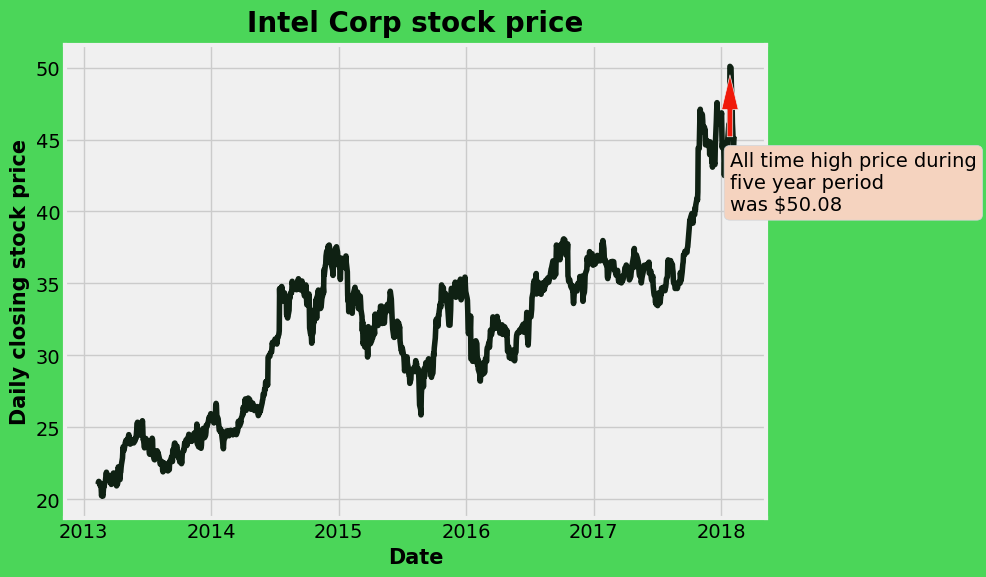

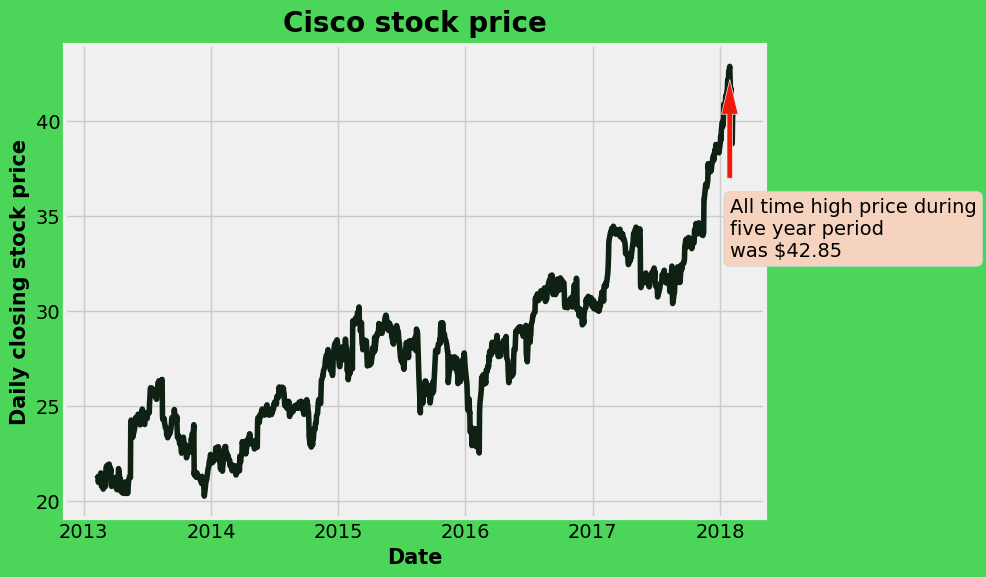

In [13]:
# function return closing stock price over a 5 years of time preriod
def closing_stock_price(df):
    # define highest stock over 5 period of time 
    high = df['close'].max()
    datetime = df[df['close'] == df['close'].max()]['date'].values
    
    if df['ticks'].unique()[0] == 'GE':
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#ed615c')
    elif df['ticks'].unique()[0] == 'F':
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#ed615c')
    else:
        fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'], df['close'], color='#0f2113')
    ax.set_title(f"{df['co_name'].unique()[0]} stock price", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily closing stock price", fontsize=15)
    if df['ticks'].unique()[0] == 'AAPL':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-35),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'F':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-3),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'FB':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-50),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'MSFT':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-20),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    elif df['ticks'].unique()[0] == 'MU':
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-15),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))
    else:
        ax.annotate(f"All time high price during\nfive year period\nwas ${high}", xy=(datetime, high),xytext=(datetime,high-10),
                bbox=dict(boxstyle="round",facecolor='#f5d3bf', edgecolor='#d0d5db'),
                 arrowprops=dict(facecolor='#f0190a',headlength=25, shrink=0.1))

    plt.show()
    
# plot of all the closing stocks
closing_stock_price(bac_df)
closing_stock_price(aapl_df)
closing_stock_price(ge_df)
closing_stock_price(f_df)
closing_stock_price(fb_df)
closing_stock_price(msft_df)
closing_stock_price(amd_df)
closing_stock_price(mu_df)
closing_stock_price(intc_df)
closing_stock_price(csco_df)
        
        

# key finding
- We could find TOP 10 most traded stocks duing period of 2013-2018.
- Out of 10 companies one is bank, 7 of them are tech companies, another two are non-tech lagacy companies namely General electric and Ford motors.
- From closing stock price visualization, we can learn that stocks 'GE' and 'F' are declining and other tech stocks are rising over a five year period time.

# Trade volume of stocks

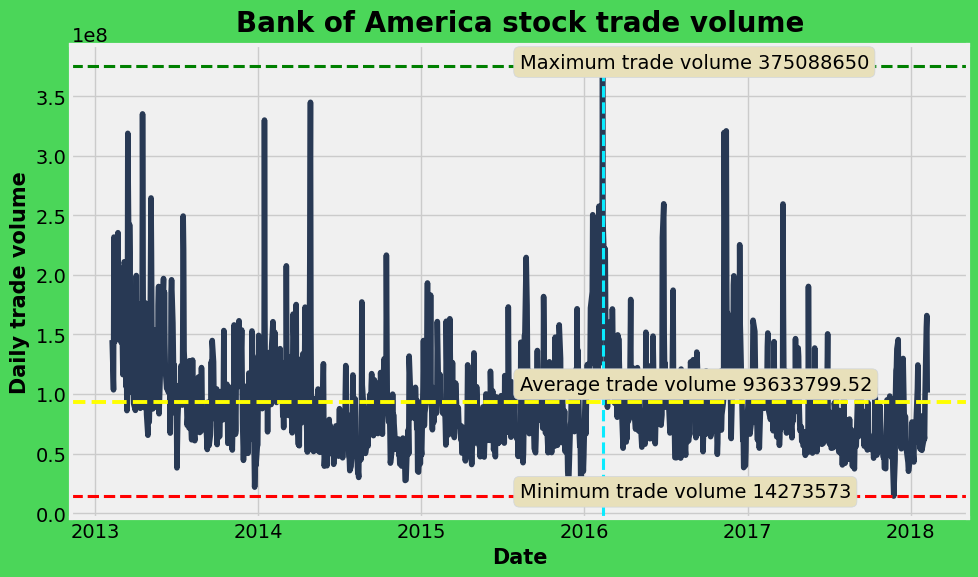

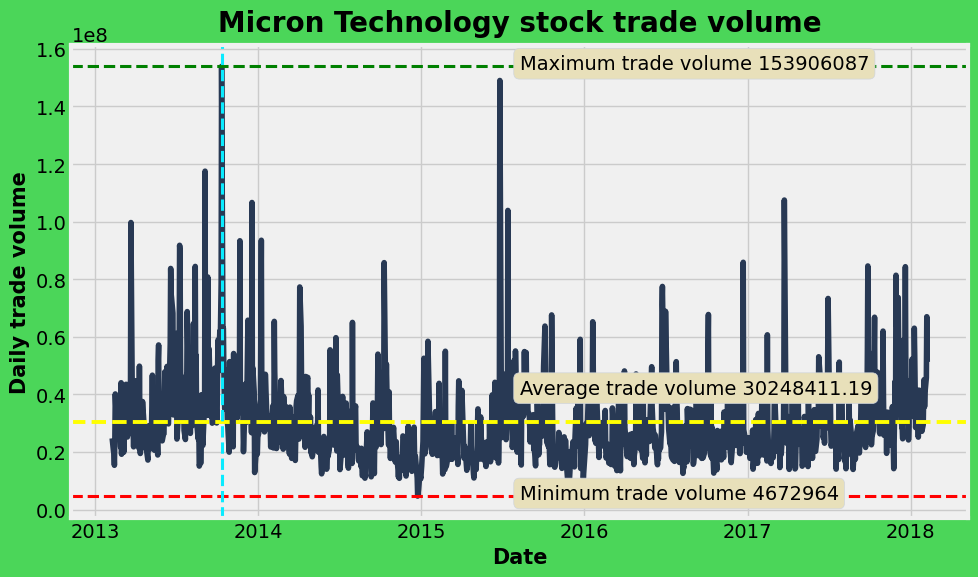

In [14]:
#function to visualize trade volume of stocks
def trade_vol(df):
    # x and y coords for average trade volume
    ave_x = df['date'].mean()
    ave_y = df['volume'].mean()
    max_y = df['volume'].max()
    min_y = df['volume'].min()
    
    fig, ax = plt.subplots(figsize=(10,6), facecolor='#4bd659')
    ax.plot(df['date'],df['volume'], color='#283954')
    ax.set_title(f"{df['co_name'].unique()[0]} stock trade volume", fontsize=20)
    ax.set_xlabel("Date", fontsize=15)
    ax.set_ylabel("Daily trade volume", fontsize=15)
    ax.axhline(y=df['volume'].max(), linestyle='--', lw=2.2, color='green')
    ax.axhline(y=df['volume'].min(), linestyle='--',lw=2.2, color='red')
    ax.axhline(y=df['volume'].mean(), linestyle='--',lw=2.8, color='yellow')
    ax.axvline(x=df[df['volume'] == max_y]['date'].values, ls='--', lw='2.2', color='#0aebff')
    ax.annotate(f"Average trade volume {round(df['volume'].mean(),2)}", 
                xy=(ave_x,ave_y),xytext=(ave_x,ave_y + 10000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Maximum trade volume {df['volume'].max()}", 
                xy=(ave_x,max_y),xytext=(ave_x,max_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    ax.annotate(f"Minimum trade volume {df['volume'].min()}", 
                xy=(ave_x,min_y),xytext=(ave_x,min_y - 1000000),
                bbox=dict(boxstyle="round",facecolor='#e8e0ba', edgecolor='#d0d5db')
                 )
    
    plt.show()
    

# plot of all stocks trade volume
trade_vol(bac_df)
trade_vol(aapl_df)
trade_vol(ge_df)
trade_vol(f_df)
trade_vol(fb_df)
trade_vol(msft_df)
trade_vol(amd_df)
trade_vol(mu_df)
trade_vol(intc_df)
trade_vol(csco_df)
    

# keyfinding
- Random increase in the trade volumes of the company
- the trade volume follow the average amount of trade values

# growth of stocks of the companies over a 5 years period

Growth rate formula = final value - initial value/initial value

In [15]:
list_df = [bac_df, aapl_df, ge_df, f_df, fb_df, msft_df, amd_df, mu_df, intc_df, csco_df]

#loop through the list to find mini and max of each stocks
mini = [df[df['date'] == df['date'].min()]['close'].values.item() for df in list_df]
maxi = [df[df['date'] == df['date'].max()]['close'].values.item() for df in list_df]

#difference between both stock price
diff = np.array(maxi) - np.array(mini)

#percentage growth
growth = (diff/mini)*100
growth_list = growth.tolist()
co_name_list = [df['co_name'].unique()[0] for df in list_df]

# visualize the growth of the stocks
fig, ax = plt.subplots(figsize=(13,7))
ax.barh(y=co_name_list, width=growth_list, height=0.9, color=['#4bd659','#4bd659','#ed615c','#ed615c','#4bd659',
                                                             '#4bd659','#4bd659','#4bd659','#4bd659','#4bd659'],
       edgecolor='#713ae8')
for p in ax.patches:
    ax.annotate(f'{round(p.get_width(),2)}%', (p.get_width()+15, p.get_y() +0.3))
ax.set_xlabel('Percentage growth in stock price')
ax.set_ylabel('Name of companies')
ax.set_title("Growth in stock price over a period of 5 years")
plt.show()

## observation
- Facebook as the hishest pancentage of growth in stock over the years
- GE and ford have a negative return over the years

# Technical analysis of stocks using candle sticks charts and moving average

Technical analysis of stocks

An open-high-low-close chart (also OHLC) is a type of chart typically used to illustrate movements in the price of a financial instrument over time. Each vertical line on the chart shows the price range (the highest and lowest prices) over one unit of time, e.g., one day or one hour. Tick marks project from each side of the line indicating the opening price (e.g., for a daily bar chart this would be the starting price for that day) on the left, and the closing price for that time period on the right. The bars may be shown in different hues depending on whether prices rose or fell in that period.

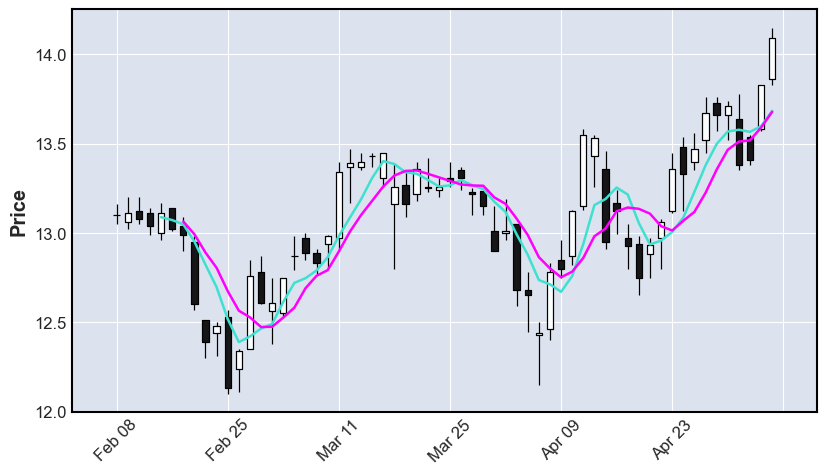

In [25]:
#using mplfinance tool
F_df = f_df.copy()
F_df.set_index('date', inplace=True)
F_df
mpf.plot(F_df.iloc[:60,:], type='candle', mav = (5,7), figratio=(9,5))

In [24]:
import mplfinance as mpf

# Candlestick charts of stocks to visualize OHLC prices

In [31]:
# using plotly graph_objs let's plot candlestick charts of stocks
def candlestick_chart(df):
    trace = go.Candlestick(x=df['date'],
                          open=df['open'],
                          high=df['high'],
                          low=df['low'],
                          close=df['close'])
    layout ={
    'title': f"{df['co_name'].unique()[0]} Historical Stock Price",
    'xaxis': {'title': 'Date'
             },
    'yaxis': {'title': 'Stock Price (USD$)'}
}
    
    
    data = [trace]
    
    fig = go.Figure(data=data, layout=layout)
    fig.update_layout(xaxis_rangeslider_visible=False, paper_bgcolor='#4bd659')
    fig.show()
    
# plot the charts using this function
candlestick_chart(bac_df)
candlestick_chart(aapl_df)
candlestick_chart(ge_df)
candlestick_chart(f_df)
candlestick_chart(fb_df)
candlestick_chart(msft_df)
candlestick_chart(amd_df)
candlestick_chart(mu_df)
candlestick_chart(intc_df)
candlestick_chart(csco_df)
                        

# Moving Averages charts of Facebook and Apple

Moving average is one of the most widly used stock market forecasting method in finance industry, in this section we will plot and analyse stocks of 'FACEBOOK' and 'APPLE' using 10, 50 and 200 days moving averages to find uptrend and downtrends


In [32]:
#define function for return with moving average dataframe
def mav_function(df):
    # moving average of 10,50 and 200 days
    df['10_d_avg'] = df['close'].rolling(window=10).mean()
    df['50_d_avg'] = df['close'].rolling(window=50).mean()
    df['200_d_avg']= df['close'].rolling(window=200).mean()
    
    return df

# let's analyse apple and facebook stocks using moving averages methods
aapl_df = mav_function(aapl_df)
fb_df = mav_function(fb_df)

In [35]:
# plot moving avearges charts of apple and facebook
aapl_dfn = aapl_df.copy()
fb_dfn = fb_df.copy()

def mav_chart(df):
    df = df.set_index('date')
    
    fig = tls.make_subplots(rows=2, cols=1, shared_xaxes=True)
    
    colors = ['#ff4500', '#92a1cf', '#6E6E6E']
    avgs = ['10_d_avg','50_d_avg','200_d_avg']
    for col, c in zip(avgs, colors):
        fig.append_trace({'x': df.index, 'y': df[col], 'type': 'scatter', 'name': col, 'line': {'color': c}},1,1)
    for col in ['close']:
        fig.append_trace({'x': df.index, 'y': df[col], 'type': 'scatter', 'name': 'closing price', 'line': {'color': '#393f5e'}},2,1)
        
    fig['layout'].update(height=800,title=f"Relationship between Moving averages <br> and Closing Price of {df['co_name'].unique()[0]}",
                    paper_bgcolor='#4bd659', plot_bgcolor='#F2DFCE')
    fig.show()

In [36]:
# plot the MAVs fo FB
mav_chart(fb_dfn)

In [37]:
# plot the MAVs of Apple
mav_chart(aapl_dfn)

# Analysis and Interpretation:

- Apple's stock price shows more irregular fluctuations compared to FB with one major decline during period of 2015-16.

- Around 7th august 2015 10 Days Moving average of Apple's stock price goes below 200 Days Moving average which shows downward trend in apple's stock price.

- And exactly, year after 15th august 2016, 10 Days Moving average crosses 200 Days Moving avearge which show uptrend thereafter.

- By comparing stocks 'FB' and 'AAPL', we can conclude that 'FB' performed better than 'AAPL'. 'FB' showed more consistant growth as well as less fluctions than 'AAPL' which proves the performance of 'FB' stocks. My recommendation is to BUY 'FB' as it has great growth prospects.